# Integrating single-cell methylation data from different scBS-seq experiments with methylVI

---

A common problem when analyzing single-cell omics datasets across multiple experiments is the presence of batch effects (i.e., systematic variations due to differences in sequencing platform). Here we demonstrate how methylVI can be used to integrate data from different single-cell bisulfite sequencing platforms. As an example, we'll consider single-cell methylomes from the dentate gyrus region of the brain collected in ["DNA methylation atlas of the mouse brain at single-cell resolution"](https://www.nature.com/articles/s41586-020-03182-8) (Liu et al., Nature, 2021) using two sequencing protocols: snmC-seq2 and snm-3C-seq.

If you use methylVI in your work, please consider citing

* Weinberger, E. and Lee, S.I. A deep generative model of single-cell methylomic data. NeurIPS 2023 Generative AI and Biology (GenBio) Workshop.

In [1]:
#!pip install --quiet scvi-colab
#from scvi_colab import install

#install()

## Imports and Data Loading

In [2]:
import mudata
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scvi
import seaborn as sns
import torch
import os
import tempfile

from scvi.external import METHYLVI

/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.0


You can modify `save_dir` below to change where the data files for this tutorial are saved.

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

This dataset was preprocessed as described in the methylVI manuscript. In particular ALLC files containing methylation reads at individual cytosines were aggregated into gene body methylation features using [ALLCools](https://lhqing.github.io/ALLCools/intro.html). Due to their distinct regulatory roles, CpG methylation and CpH methylation (i.e., non-CpG methylation) were considered separately. The resulting methylation count features were stored in a `MuData` object with separate modality fields for each methylation context: `mCG` (for CpG methylation) and `mCH` for CpH methylation.

In [5]:
mdata_path = os.path.join(save_dir.name, "Liu2021_batch.h5mu")

if not os.path.exists(mdata_path):
    os.system(f"wget -q -O {mdata_path} https://figshare.com/ndownloader/files/49632108")

mdata = mudata.read_h5mu(
    mdata_path
)
mdata.mod

/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData
├─ mCG AnnData (10726 x 2500)
└─ mCH AnnData (10726 x 2500)

Within the modality-specific `AnnData` objects, the coverage (i.e., number of measured cytosines) within each gene body region for a cell can be found in the `cov` layer, while the number of methylated cytosines can be found in the `mc` layer.

In [6]:
mdata['mCG'].layers

Layers with keys: cov, mc

Finally, normalized methylation counts for each region (computed using the `add_mc_frac` function in ALLCools) can be found in the `AnnData` objects' `.X` fields.

In [7]:
mdata['mCG'].X

array([[ 0.        ,  0.        , -0.34459764, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62912544,  0.96123438,  0.90394941, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.88005841, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.87361881, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10159167,  0.        ,  0.48925986, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.367354  , ...,  0.        ,
         0.        ,  0.        ]])

Now we'll briefly explore our data. To do so, we'll follow the ALLCools workflow detailed [here](https://lhqing.github.io/ALLCools/cell_level/basic/mch_mcg_100k_basic.html) to combine information from the two methylation contexts (i.e., CpG and CpH methylation). In particular, we'll apply principal component analysis (PCA) to each modality, and then aggregate the resulting PCs.

In [8]:
sc.tl.pca(mdata['mCG'])
sc.tl.pca(mdata['mCH'])

ch_pcs = mdata['mCH'].obsm['X_pca']
cg_pcs = mdata['mCG'].obsm['X_pca']

# standardize the values of PCs from both modalities
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

mdata.obsm['X_pca'] = total_pcs

Now we'll visualize our data with UMAP. We find that there exist clear batch effects between the two sequencing protocols, with clear separation by protocol (left) in addition to variations due to cell type differences (right).

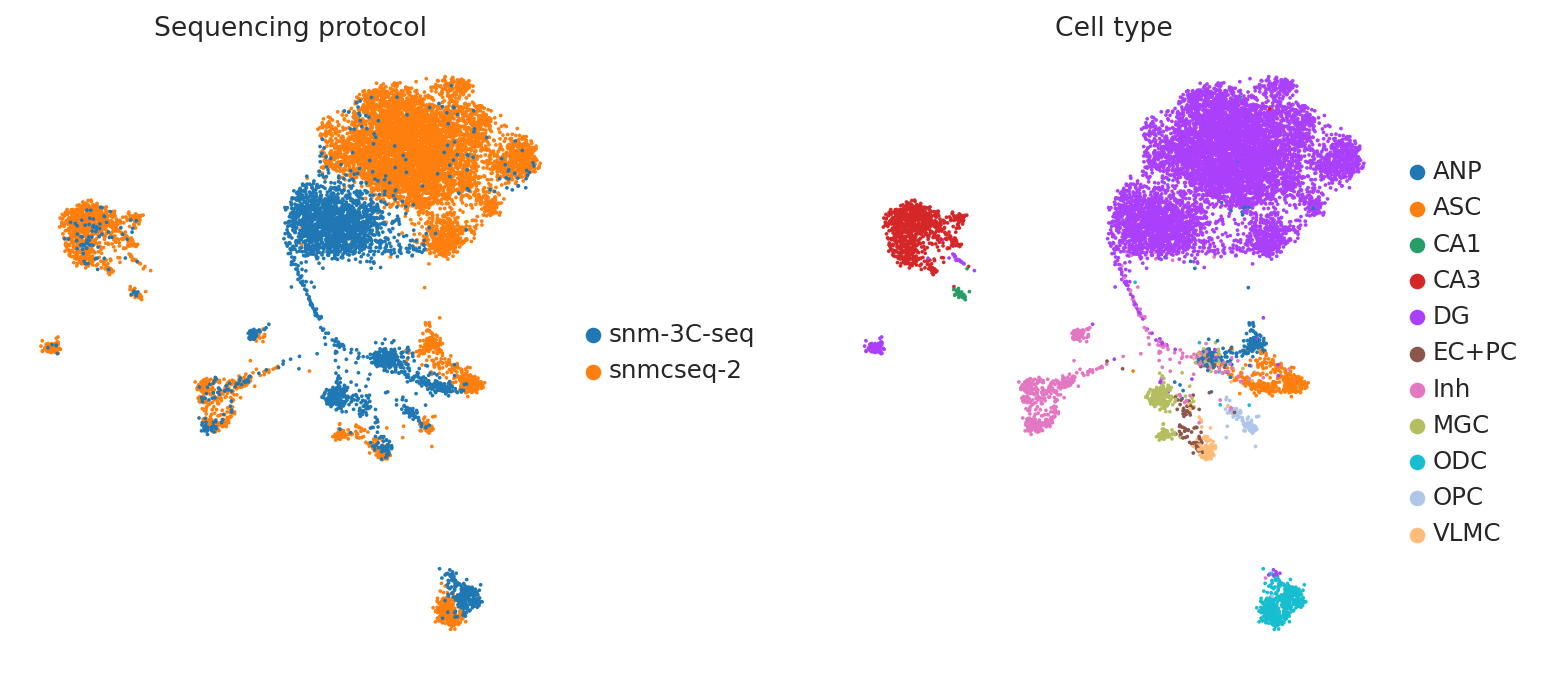

In [9]:
sc.pp.neighbors(mdata)
sc.tl.umap(mdata)

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

sc.pl.umap(mdata, color='mCG:Platform', ax=ax[0], show=False, title="Sequencing protocol")
sc.pl.umap(mdata, color='mCG:CoarseType', ax=ax[1], show=False, title="Cell type")

plt.subplots_adjust(wspace=0.5)

In the next section, we'll see how methylVI can alleviate these issues.

# Prepare and run model

Before training our model, we'll use methylVI's `setup_mudata` function to prepare our `MuData` object for training. 

First, we need to tell methylVI which modalities in our MuData object to consider via the `methylation_contexts` argument. Here we'll jointly model CpG and non-CpG methylation, so we'll set this argument to a list containing the names of both modalities. Next, methylVI directly models the total coverage and number of methylated cytosines in each region. Thus, for each modality in our `MuData` object, we need layers containing the coverage in each region (specified by `cov_layer`) and layers with the number of methylated cytosines (specified by `mc_layer`). Finally, we'll provide methylVI with a categorical covariate specifying the sequencing protocol used for each cell, and we'll specify which modality's `.obs` field contains this covariate. Here the `.obs` fields are identical for both modalities, so we arbitrarily tell methylVI to look in the `mCG` modality for our covariate.

In [10]:
METHYLVI.setup_mudata(
    mdata,
    mc_layer="mc",
    cov_layer="cov",
    methylation_contexts=["mCG", "mCH"],
    categorical_covariate_keys=["Protocol"],
    modalities={"categorical_covariate_keys": "mCG"},
)

Next, we declare a `METHYLVI` model object with 20 latent variables as done in the methylVI manuscript, and train our model with early stopping.

In [11]:
model = METHYLVI(
    mdata,
    n_latent=20,
)

model.train(max_epochs=500, early_stopping=True)

INFO     The model has been initialized                                                                            


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/homes/gws/ewein/micromamba/envs/scvi-dev-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. C

Epoch 355/500:  71%|▋| 355/500 [06:44<02:45,  1.14s/it, v_num=1, train_loss_step=5.24e+3, train_
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 5483.267. Signaling Trainer to stop.


Now that our model is trained, we'll obtain latent representations of each cell.

In [12]:
mdata.obsm['methylVI'] = model.get_latent_representation()

Visualizing these representations, we find that cells now mix across protocol (left) while separating by cell type (right).

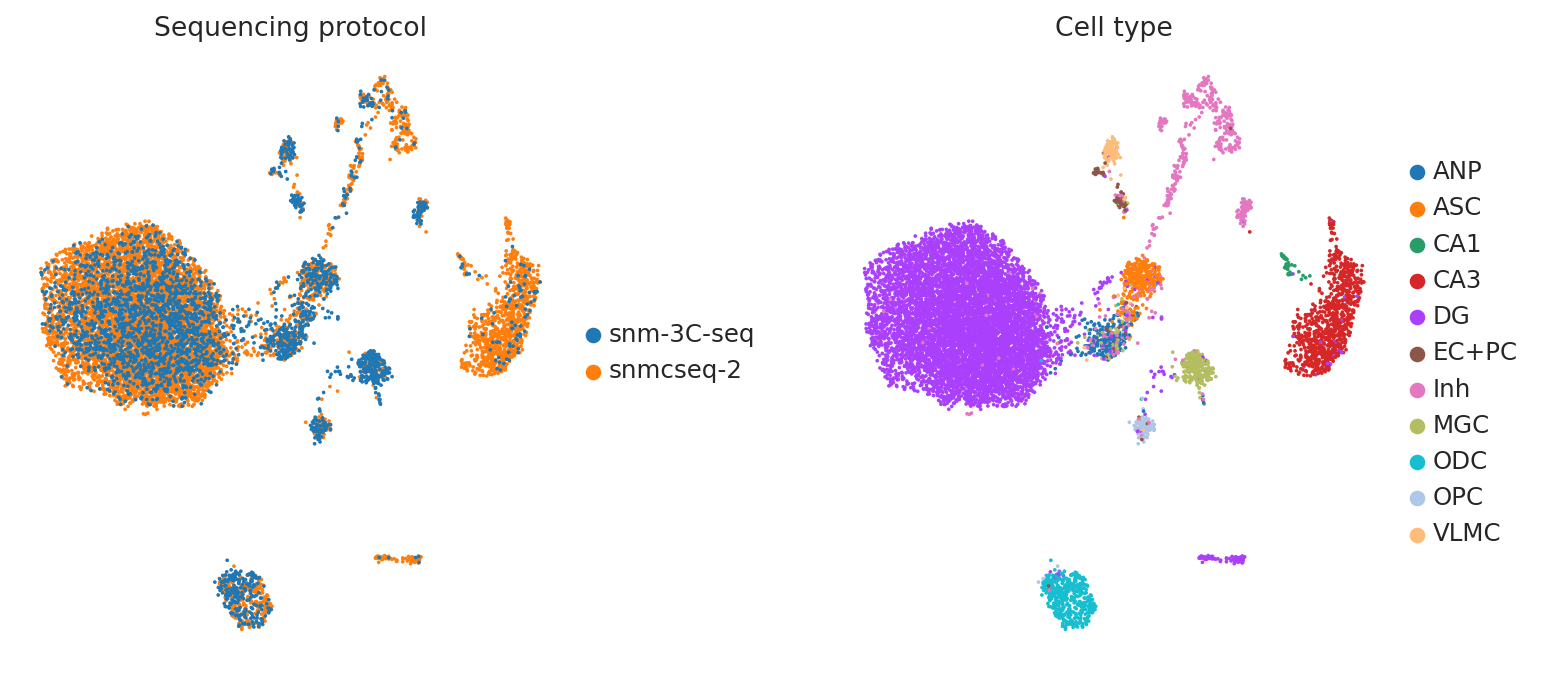

In [13]:
sc.pp.neighbors(mdata, use_rep='methylVI')
sc.tl.umap(mdata)

fig, ax = plt.subplots(1, 2, figsize=(11, 5))

sc.pl.umap(mdata, color='mCG:Platform', ax=ax[0], show=False, title="Sequencing protocol")
sc.pl.umap(mdata, color='mCG:CoarseType', ax=ax[1], show=False, title="Cell type")

plt.subplots_adjust(wspace=0.5)